# Guruprasad Velikadu Krishnamoorthy
# DSC530- Assignment Week 10

## Initial Setup

In [1]:
# Download basename and exists from OS module which will be used in the download function
from os.path import basename, exists

# Create a function named download_file, to dounload the scripts and files from Github to local path
def download_files(url):
    """
    Downloads the scripts/ files from Github to local directory
    takes url as input.
    """
    filename = basename(url)
    # Checking if the file exists in the local directory and it downloads the file if it doesn't exist already.
    if not exists(filename):
        from urllib.request import urlretrieve
        # Downloading the files to the local path
        local, _ = urlretrieve(url, filename)
        # Printing confirmation message
        print("Downloaded " + local)

In [2]:
#  Calling download functions to download .py files and data files used throughtout this assignment
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download_files("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")

Downloaded thinkstats2.py
Downloaded thinkplot.py
Downloaded mj-clean.csv


In [3]:
# Importing the libraries and other modules module from the author's code
import thinkstats2
import thinkplot

# importing the required libraries
import numpy as np
import sys
from collections import defaultdict
import math
import itertools
import pandas as pd
import scipy.stats as sci
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import patsy

# Exercise 12.1

#### ***Question:*** The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in  "Nonlinear Relationships" on page 133.

#### Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of RunLinearModel that runs that quadratic model, but after that you should be able to reuse code from in timeseries.py to generate predictions.

#### ***Overview of Approach:*** After creating dataframe of the m-clean.csv, we group the data based on Dates and Quality values.  We then create a Linear model called quadratic model that predicts price per gram based on the year. We then run sampling based on the residuals and based on results from each sampling iterations, we generate predictsions and plot the predicted results. 

In [4]:
# Creating a pandas dataframe by reading the source file and printing top 5 rows
mj_original_df = pd.read_csv("mj-clean.csv", parse_dates=[5])
mj_original_df.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [5]:
def GroupByDate(input_df, funct=np.mean):
    """Groups transactions by date and compute the daily mean ppg.
    input_df: DataFrame of transactions
    returns: DataFrame of daily prices
    """
    # Grouping the data based on date and price per gram
    grouped_date = input_df[["date", "ppg"]].groupby("date")
    # Creating a new dataframe that contains mean value ofprice per gram far each date in the dataframe
    grouped_date_mean_df = grouped_date.aggregate(funct)
    # Assigning date of the dataframe as the Index
    grouped_date_mean_df["date"] = grouped_date_mean_df.index
    # To compute the number of the year, we calculate the start date and measure the relative difference
    start_date = grouped_date_mean_df.date[0]
    one_year = np.timedelta64(1, "Y")
    # Adding new field years to the dataframe
    grouped_date_mean_df["years"] = (grouped_date_mean_df.date - start_date) / one_year
    return grouped_date_mean_df

In [6]:
def GroupByQualityAndDay(input_df):
    """Divides transactions by quality and computes mean daily price.
    input_df: DataFrame of transactions
    returns: map from quality to time series of ppg
    """
    # The dataframe is grouped by the field Quality
    quality_groups = input_df.groupby("quality")
    # Creating a dictionary to capture each group that is grouped by Quality
    Quality_date_dict = {}
    # Loop through each item in the Groups of quality created in step above and add each item to the
    # dictionary. The dataframe is grouped on date and also on Quality
    for quality_name, quality_group in quality_groups:
        Quality_date_dict[quality_name] = GroupByDate(quality_group)
    return Quality_date_dict

In [7]:
# The function GroupByQualityAndDay is used to group the dataframe based on date and Quality values.
grouped_quality_date_dict = GroupByQualityAndDay(mj_original_df)
grouped_quality_date_dict

{'high':                   ppg       date     years
 date                                      
 2010-09-02  13.384186 2010-09-02  0.000000
 2010-09-03  14.459588 2010-09-03  0.002738
 2010-09-04  14.923333 2010-09-04  0.005476
 2010-09-05  16.667500 2010-09-05  0.008214
 2010-09-06  15.537500 2010-09-06  0.010952
 ...               ...        ...       ...
 2014-05-09  11.468298 2014-05-09  3.682485
 2014-05-10  10.532326 2014-05-10  3.685223
 2014-05-11  11.518750 2014-05-11  3.687961
 2014-05-12  10.578293 2014-05-12  3.690699
 2014-05-13   9.604615 2014-05-13  3.693437
 
 [1241 rows x 3 columns],
 'low':                   ppg       date     years
 date                                      
 2010-09-02   4.943750 2010-09-02  0.000000
 2010-09-03   3.984138 2010-09-03  0.002738
 2010-09-04   3.530000 2010-09-04  0.005476
 2010-09-10   4.240000 2010-09-10  0.021903
 2010-09-14   6.066118 2010-09-14  0.032855
 ...               ...        ...       ...
 2014-05-09  14.700000 2014-05-09

In [8]:
def RunQuadraticModel(grouped_quality_df):
    """Runs a linear model of prices versus years and years**2.
    grouped_quality_date_dict_item: DataFrame of daily prices grouped by Quality.
    returns: model, results
    """
    # Adding a new field called Years2 to the dataframe which is the square of year. This is predict Nonlinear relationships
    grouped_quality_df["years2"] = grouped_quality_df.years**2
    # Use statsmodel to create a model that predicts price per gram from year and year**2
    model_quad = smf.ols("ppg ~ years + years2", data=grouped_quality_df)
    # Returning the results of the model.
    results_quad = model_quad.fit()
    return model_quad, results_quad

In [9]:
def RunLinearModel(grouped_quality_date_dict_item):
    """Runs a linear model of prices versus years .
    grouped_quality_date_dict_item: DataFrame of daily prices grouped by Quality.
    returns: model, results
    """
     # Use statsmodel to create a model that predicts price per gram from year 
    model_lin = smf.ols("ppg ~ years", data=grouped_quality_date_dict_item)
    # Returning the results of the model.
    results_lin = model_lin.fit()
    return model_lin, results_lin

In [10]:
# As an example, we use the group of "High" quality values.
quality_name = "high"
grouped_quality_df = grouped_quality_date_dict[quality_name]
#Run the RunQuadraticModel on the "High" quality group dataframe
model_quad, results_quad = RunQuadraticModel(grouped_quality_df)
# Print the summary of results
results_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sat, 20 May 2023   Prob (F-statistic):          4.57e-164
Time:                        10:59:37   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Results of the model indicate that the the price per gram decreases as the years increase, due to the negative intercept of years. Also the R2 value represents strong correlation (negative) between the year and ppg. The p-values are much smaller indicating significant results.

In [11]:
def PlotFittedValues(model_quad, results_quad, label=""):
    """Plots original data and fitted values.
    model_quad: StatsModel model object
    results: StatsModel results object
    """
    # Assigning the Explanatory variables to years variable and taking values of 2nd column that year values of years.
    model_quad_years = model_quad.exog[:,1]
    # Assigning the dependent variable(ppg)
    model_quad_values = model_quad.endog
    # Creating scatter plot of Years vs ppg from the model results
    thinkplot.Scatter(model_quad_years, model_quad_values, s=10, label=label)
    # Creating a linear plot of years vs ppg
    thinkplot.Plot(model_quad_years, results_quad.fittedvalues, label="model", color="green")

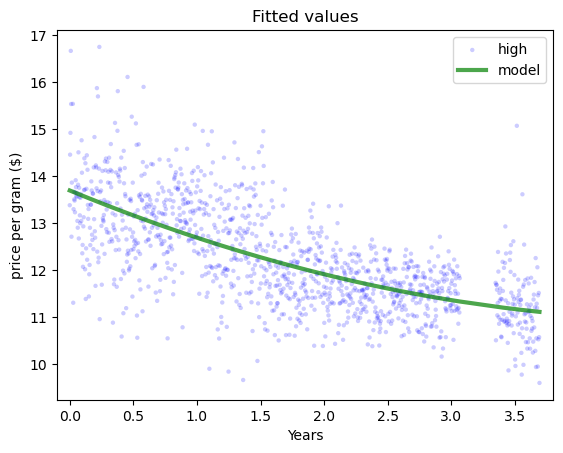

In [12]:
# Plot the results of the model
PlotFittedValues(model_quad, results_quad, label=quality_name)
thinkplot.Config(
    title="Fitted values", xlabel="Years", xlim=[-0.1, 3.8], ylabel="price per gram ($)"
)

In [13]:
def SimulateResults(grouped_quality_df, iterations=101, funct=RunQuadraticModel):
    """This runs simulations of the resampled data.
    grouped_quality_date_dict_item: DataFrame of daily prices
    iters: number of simulations
    func: function that fits a model to the data
    returns: list of result objects
    """
    # Run the RunQuadraticModel function on the input Dataframe
    modl, results = funct(grouped_quality_df)
    # Creating a copy of the dataframe on which the simulations will be run
    df_copy = grouped_quality_df.copy()
    # Creating a list to store the simulation results
    results_simulations = []
    # Loop through number of iterations to sample the data and run the Quadratic model
    for iterat in range(iterations):
        # For resampling the data, we add the original model results and resampled residuals to compute ppg        # which will be used further for creating simulation models
        df_copy.ppg = results.fittedvalues + thinkstats2.Resample(results.resid)
        # Create Quadratic model using the newly calculated values of ppg.
        modl_cp, df_copy_results = funct(df_copy)
        # Model results from each iteration is added to the list results_simulations
        results_simulations.append(df_copy_results)
    return results_simulations

In [14]:
def GeneratePredictions(results_simulations, years, add_resid=False):
    """Generates an array of predicted values from a list of model results.
    When add_resid is False, predictions represent sampling error only.
    When add_resid is True, they also include residual error (which is
    more relevant to prediction).
    results_simulations: list of model results
    years: sequence of times (in years) to make predictions for
    add_resid: boolean, whether to add in resampled residuals
    returns: sequence of predictions
    """
    # Create a dataframe of intercept, year and years**2. This will be used to predict the ppg.
    nbr_years = len(years)
    # Creating a dictionary of intercept, year and year**2 to match the structure of dataframe with 3 columns
    predict_dict = dict(Intercept=np.ones(nbr_years), years=years, years2=years**2)
    # Creating a dataframe for prediction from the dictionary
    predict_df = pd.DataFrame(predict_dict)
    # Creating a list to capture the results from Predict method.
    predict_simulations = []
    # Iterate through each result from the simulations and use Predict method
    for result_simulate in results_simulations:
        # Use the predict method to predict the ppg based on the input years
        predict_result = result_simulate.predict(predict_df)
        # Add_resid boolean is to include the residual error in the predicted results.
        # To add the residual error we add the residual values of the model to the predicted value
        if add_resid:
            predict_result += thinkstats2.Resample(result_simulate.resid, nbr_years)
        # Append all prediction results to the predict_simulations list
        predict_simulations.append(predict_result)
    return predict_simulations

In [25]:
def PlotPredictions(grouped_quality_df, years, iterations=101, prcnt=90, funct=RunQuadraticModel):
    """Plots predictions.
    grouped_quality_df: DataFrame of daily prices grouped by quality
    years: sequence of times (in years) to make predictions for
    iterations: number of simulations
    prcnt: what percentile range to show
    func: function that fits a model to the data
    """
    # The results of simulation from Simulate function are stored in a list
    results_simulations = SimulateResults(grouped_quality_df, iterations=iterations, funct=funct)
    # Calculating the percentile to show the results of prediction in the plot
    p = (100 - prcnt) / 2
    # If the percent is 90, we plot 5 to 95 percentiles
    prcnts = p, 100 - p
    # Create predictions on simulated model results with residual flag enabled
    predict_simulations = GeneratePredictions(results_simulations, years, add_resid=True)
    # Results from Predictions will be plotted between the high and low percentiles 
    low, high = thinkstats2.PercentileRows(predict_simulations, prcnts)
    thinkplot.FillBetween(years, low, high, alpha=0.3, color="pink")
    # Create predictions on simulated model results with residual flag enabled
    predict_simulations = GeneratePredictions(results_simulations, years, add_resid=False)
    # Results from Predictions will be plotted between the high and low percentiles 
    low, high = thinkstats2.PercentileRows(predict_simulations, prcnts)
    thinkplot.FillBetween(years, low, high, alpha=0.5, color="blue")

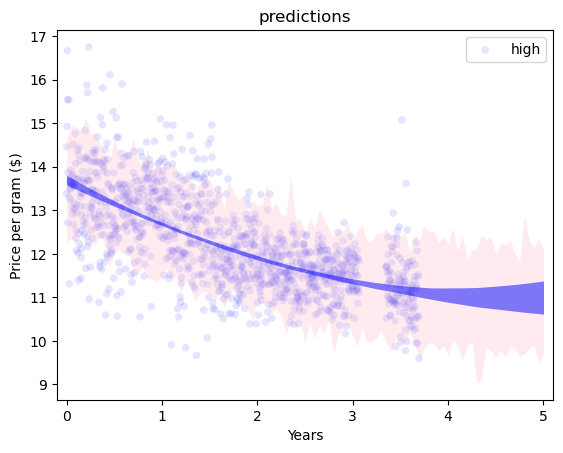

In [26]:
# Creating sample years from 0 to 5 that will be used further for predictions
years = np.linspace(0, 5, 101)
# Creating scatter plot of years vs ppg
thinkplot.Scatter(grouped_quality_df.years, grouped_quality_df.ppg, alpha=0.1, label=quality_name)
# Plotting the predictions from simulated models created from functions created above
PlotPredictions(grouped_quality_df, years, funct=RunQuadraticModel)
thinkplot.Config(
    title="predictions",
    xlabel="Years",
    # Setting the limits for x axis by adding 0.1 to the first and last values
    xlim=[years[0] - 0.1, years[-1] + 0.1],
    ylabel="Price per gram ($)",
)

# Exercise 12.2

#### ***Question:*** **Exercise:** Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

#### Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

#### ***Approach:***  Before creating the function SerialCorrelationTest, we first create a parent class HypothesisTest_base (which is based on thinkstats methods such as CreateTestStatistic, create_pvalue etc. The SerialCorrelationTest will be an abstract call that contains function to create Test statistic on correlation results on a input series.  The Hypothesis test is then run by shuffling the data on "price per gram" field using permutation method and results of hypothesis test are then used to compute the P-Value of raw data, linear model and Quadratic model     

In [17]:
# Below is the HypothesisTest Class based on thinkstats2 module
class HypothesisTest_base(object):
    """
    An abstract lass that conducts Hypothesis test. Code is referenced from thinkstats2.
    """
    # This is the initial setup. whenever the class is invoked, this part will execute
    def __init__(self, input_data):
        self.input_data = input_data
        # Performs initial processing setup such as deriving array lengths., etc and builds a representation
        # of Null hypothesis.
        self.CreateModel()
        # Deriving actual value. This will be used for comparison while running hypothesis tests.
        self.actual_value = self.CreateTestStatistic(input_data)
        

    # This method computes the final PValue. 
    def calculate_PValue(self, iterations=1000):
        # This loops through the number of iterations and calls ExecuteModel module and collects results in a list
        self.model_outputs = [self.CreateTestStatistic(self.ExecuteModel()) for _ in range(iterations)]
        # This compares the actual value with each value in the test_stats list. If the test_stats value is greate
        # the result will be captured in the count variable.
        #print(self.actual_value)
        eligible_count = sum(1 for model_output in self.model_outputs if model_output >= self.actual_value)
        # The ratio of count to number of iterations is the P-Value
        #print(eligible_count / iterations)
        return eligible_count / iterations

    # Placeholder method for CreateTestStatistic. Raises exception if not defined
    def CreateTestStatistic(self, input_data):
        raise UnimplementedMethodException()

    # Placeholder method for MakeModel. 
    def CreateModel(self):
        pass
    
    # Placeholder method for RunModel. Raises exception if not defined
    def ExecuteModel(self):
        raise UnimplementedMethodException()

In [18]:
def SerialCorr(input_series, lag=1):
    """
    This function computes the serial correlation of a series by shifting the values in the series 
    per the lag defined.
    input_series : The input series on which serial correlation should be calculated.
    lag: The lag used on the series to calculate correlation
    """
    # creating variables for series to calculate the correlation
    series_xs = input_series[lag:]
    series_ys = input_series.shift(lag)[lag:]
    # Correlation is calculated here between the series and series with lag,
    correlation = thinkstats2.Corr(series_xs, series_ys)
    return correlation

In [19]:
class SerialCorrelationTest(HypothesisTest_base):
    """An abstract class of HypothesisTest_base. Tests serial correlations by permutation."""

    def CreateTestStatistic(self, input_data):
        """Computes the test statistic. This method will be invoked during the init of the class and when 
        p-value is being calculated.
        input_data: tuple of input series and lag.
        """
        # input series and the lag in the input is read as a tuple
        input_series, lag = input_data
        # Serial correlation of Input series is computed
        test_statistic = abs(SerialCorr(input_series, lag))
        return test_statistic

    def ExecuteModel(self):
        """Run the model of the null hypothesis. In this case we use permutation method of shuffling the
        input data for simulating and performing the test.
        returns: simulated data
        """
         # input series and the lag in the input is read as a tuple
        input_series, lag = self.input_data
        # for the null hypothesis testing, permutation method of shuffling the index is used
        permut_data = input_series.reindex(np.random.permutation(input_series.index))
        return permut_data, lag

In [20]:
# Compute the serial correlation of the series with the given lag and calculate the p-value
# In this example we select the quality value of high
quality_name = "high"
# Createing a dataframe that is grouped for Quality of High 
grouped_quality_df = grouped_quality_date_dict[quality_name]
# The series will be of ppg value
input_series = grouped_quality_df.ppg
# Hypthesis test for ppg will be run for lag of 1
hypoth_test1 = SerialCorrelationTest((input_series, 1))
# After running the simulations for various iterations, the p-value will be calculated based on
# how many number of tests had correlations greater than the actual correlation in the series
pvalue1 = hypoth_test1.calculate_PValue()
print(f"The actual value of Hypthesis test is {hypoth_test1.actual_value} and P-value is {pvalue1}")

The actual value of Hypthesis test is 0.4852293761947381 and P-value is 0.0


#### Use this class to test whether the serial correlation in raw price data is statistically significant
#### ***Solution:*** As the p-value is close to 0, the results of correlation in raw price data is statistically significant, which means out of hypothesis test that was run 1000 times, none of the test could arrive at a correlation as significant as 0.485 that the original data had. 

In [21]:
# Testing serial correlation in residuals of the linear model
# Running the linear model and storing the results in variables
model1_lin, results_lin = RunLinearModel(grouped_quality_df)
# Creating series of residuals from linear model
series_lin = results_lin.resid
# Running Hypothesis test on the residuals from Linear model with a lag of 1
hypoth_test2 = SerialCorrelationTest((series_lin, 1))
# After running the simulations for various iterations, the p-value will be calculated based on
# how many number of tests had correlations greater than the actual correlation in the residual series
pvalue2 = hypoth_test2.calculate_PValue()
print(f"The actual value of Hypthesis test on Residuals of Linear model is {hypoth_test2.actual_value} and P-value is {pvalue2}")

The actual value of Hypthesis test on Residuals of Linear model is 0.07570473767506265 and P-value is 0.011


In [22]:
# Testing serial correlation in residuals of the Quadratic model
# Running the Quadratic model and storing the results in variables
model2_quad, results2_quad = RunQuadraticModel(grouped_quality_df)
# Creating series of residuals from Quadratic model
series_quad = results2_quad.resid
# Running Hypothesis test on the residuals from Quadratic model with a lag of 1
hypoth_test3 = SerialCorrelationTest((series_quad, 1))
# After running the simulations for various iterations, the p-value will be calculated based on
# how many number of tests had correlations greater than the actual correlation in the residual series
pvalue3 = hypoth_test3.calculate_PValue()
print(f"The actual value of Hypthesis test on Residuals of Quadratic model is {hypoth_test3.actual_value} and P-value is {pvalue3}")

The actual value of Hypthesis test on Residuals of Quadratic model is 0.05607308161289916 and P-value is 0.054


#### Based on the results of p-value of linear and quadratic models, the results are stistically signifiant as the p-value is close to the borderline of 0.05